# graphs_notebook
This is a test using Jupyter notebook for our graphs in R

### First, we load in the required libraries.

In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
library(viridis)
library(vegan)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: viridisLite

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-5


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Then, we read in the data from our GitHub repo and generate some tables.

In [2]:
data <- fread("CREST_BWA_final.txt")
tax <- select(data, superkingdom:genus) # Right now no species are picked because the information is kind of unequally organized
spe <- data[[18]]

### Now, we create a taxlist vector with contains each phylum per row in the taxonomy table (or if phylum = NA, then superkingdom).

In [3]:
taxlastrow <- nrow(tax)
taxlist <- rep(NA,nrow(tax))
for (i in 1:nrow(tax))
{ if (tax[i,1] == "Unknown")
{ taxlist[i] <- tax[i,1] }
  else if (is.na(tax[i,3]) == TRUE)
  { taxlist[i] <- paste(tax[i,1], ": Unknown", sep="") }
  else
  { taxlist[i] <- paste(tax[i,1], ": ", tax[i,3], sep="") }
}

### We combine read count and taxonomic group information and aggregate them based on groups.

In [4]:
plot_table <- as.data.table(cbind(taxlist,spe))
plot_agg <- aggregate(unlist(plot_table[[2]])~unlist(plot_table[[1]]),data=plot_table,FUN=sum)
colnames(plot_agg) <- c("Group", "Reads")
plot_agg_ordered <- plot_agg[order(as.character(plot_agg$Group)),]
plot_agg_ordered$Group <- factor(plot_agg_ordered$Group, levels=plot_agg_ordered$Group)

### Let's also set some nice colors for plots.

In [5]:
viridis_colors <- viridis_pal(option = "D")(nrow(plot_agg_ordered)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002) # Set seed for randomizations so that it's reproducible
colorvec1 <- sample(viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish
colorvec2 <- c("#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7", "#f3e1eb", "#f6c4e1", "#f79cd4", "#4a6fe3", "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a")

### Now, we can finally start plotting. First, we plot our one sample, which represents one combination of programs in our pipeline.

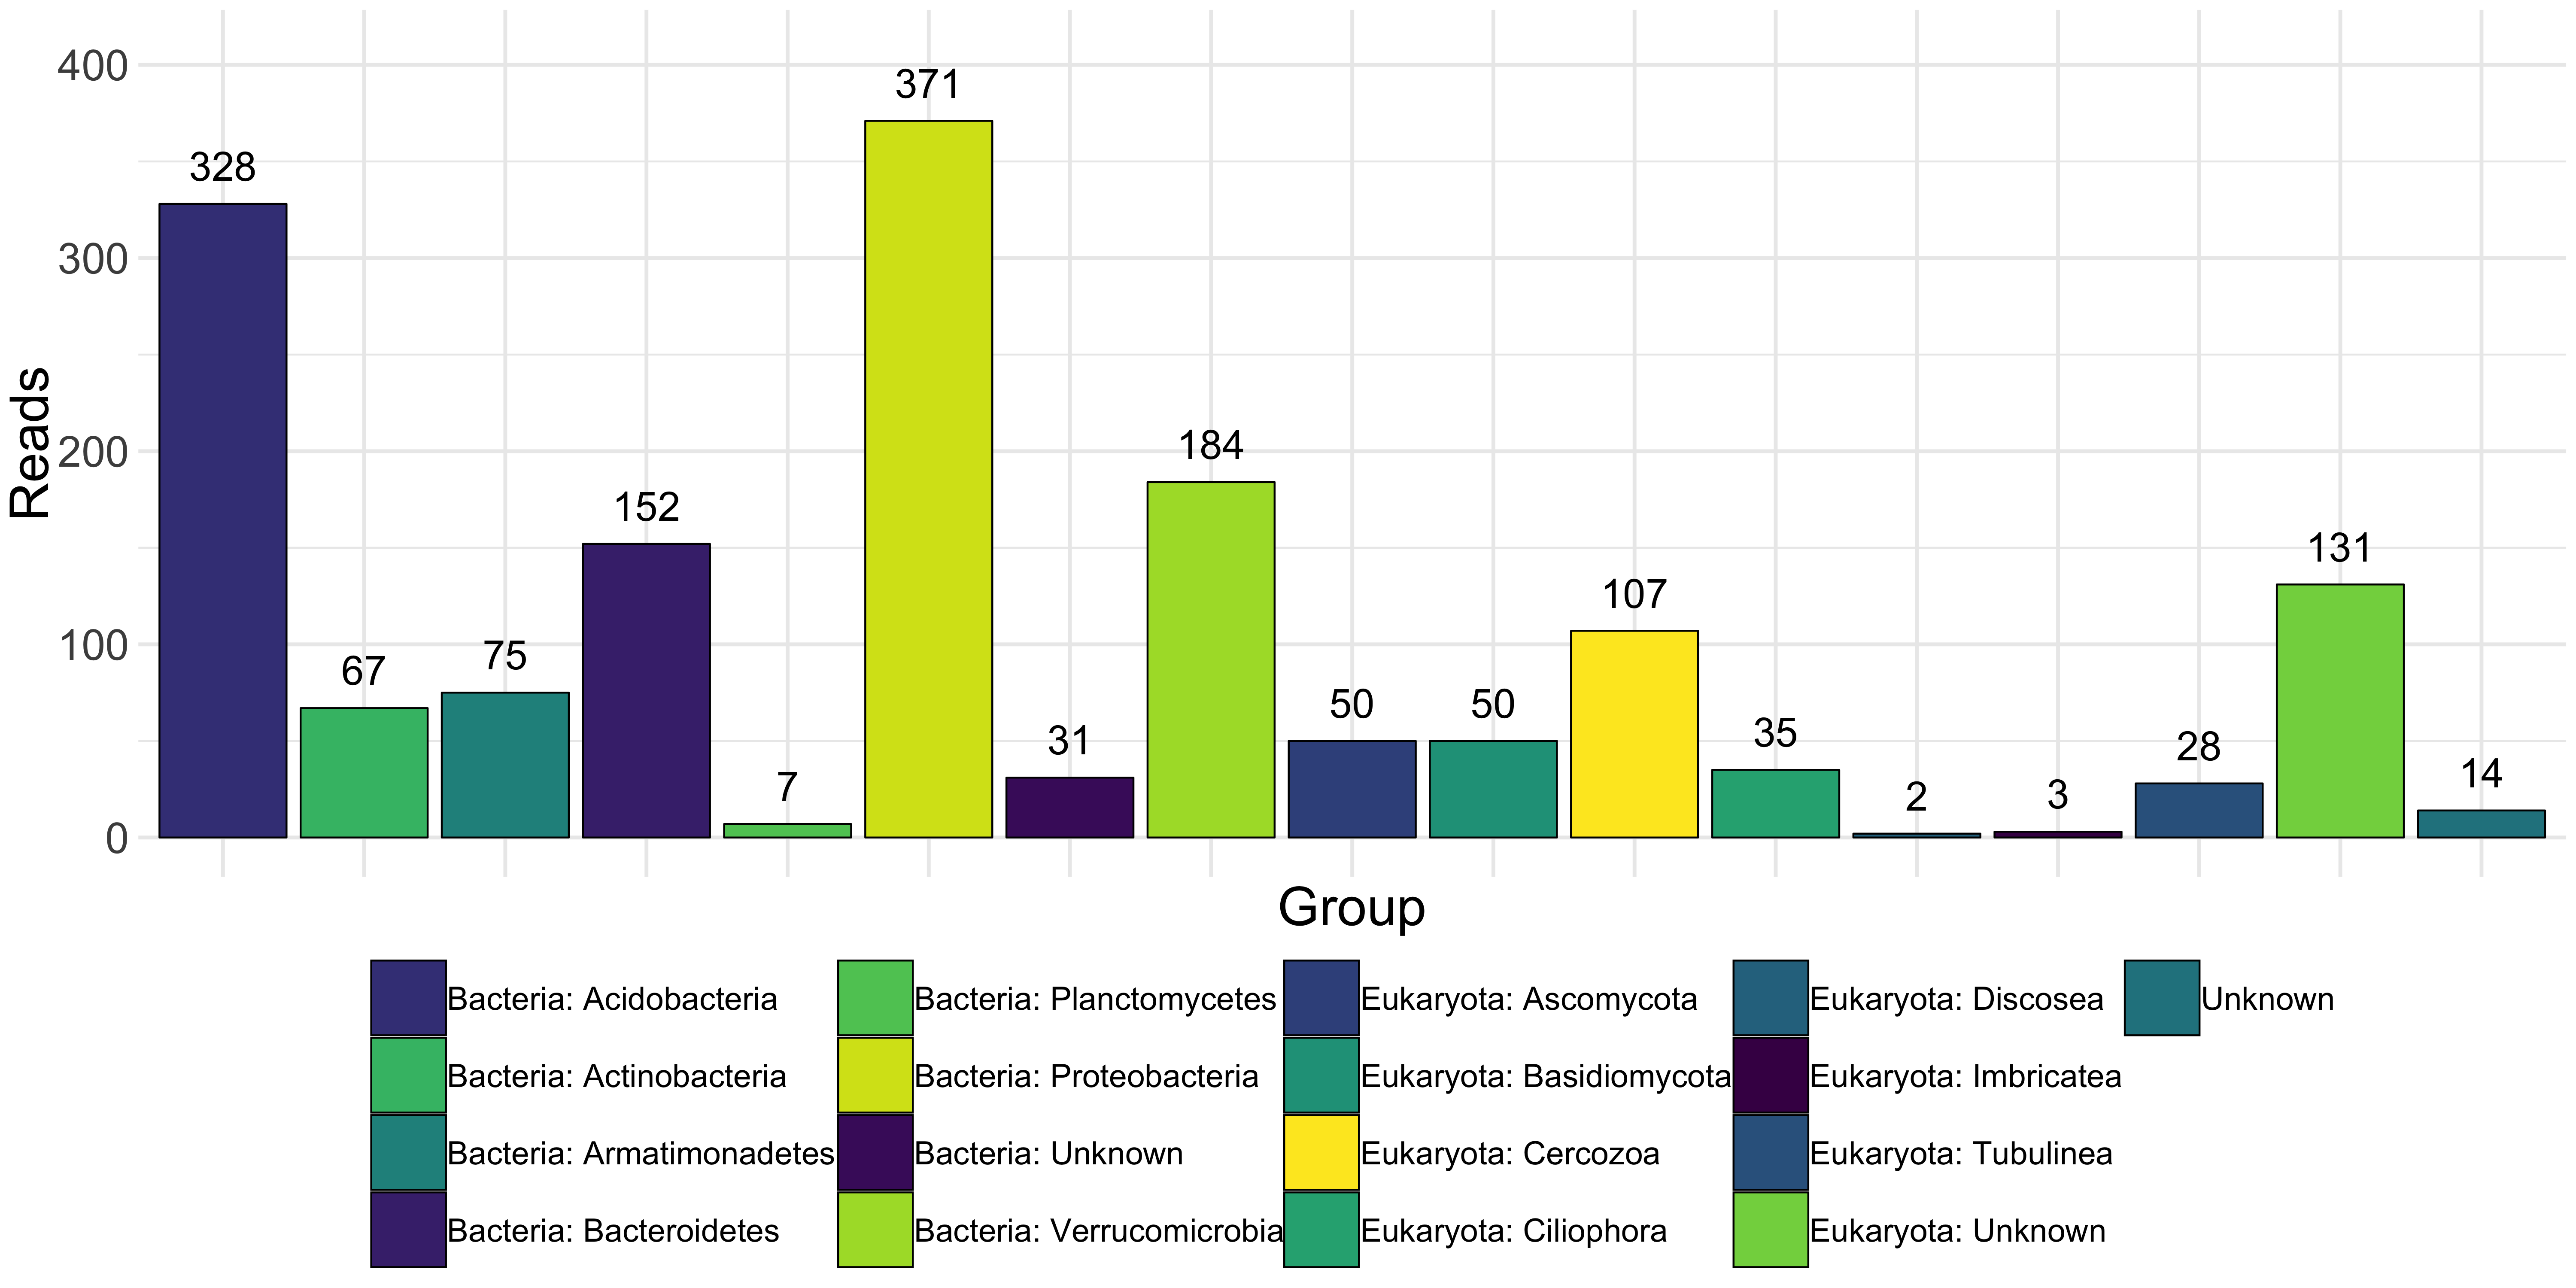

In [6]:
plot1<-ggplot(data=plot_agg_ordered, aes(x=Group, y=Reads, fill=Group))+
  geom_bar(stat="identity", color="black")+
  ylim(0,1.1*max(plot_agg_ordered$Reads))+
  theme_minimal()+
  scale_fill_manual(values=colorvec1)+
  geom_text(aes(label=Reads), vjust=-0.8, size=8)+
  theme(legend.key.size = unit(3,"line"))+
  theme(axis.text.x=element_blank())+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  theme(element_line(size = 1))

options(repr.plot.width=20, repr.plot.height=10, repr.plot.res=300)
plot1
#ggsave("Plot.png", plot=plot1,  device="png")  #uncomment if you want to save the plot as .png (currently wrong size, rather save it manually by right-clicking o picture)

### But for our real data, we will have more than just one combination. So let's pretend we have more and create new random samples which represent data of other combinations and plot them as stacked barplots.

In [7]:
sample_2 <- round(runif(nrow(plot_agg_ordered), 0, max(plot_agg_ordered$Reads)))
sample_3 <- round(runif(nrow(plot_agg_ordered), 0, max(plot_agg_ordered$Reads)))
sample_4 <- round(runif(nrow(plot_agg_ordered), 0, max(plot_agg_ordered$Reads)))
sample_5 <- round(runif(nrow(plot_agg_ordered), 0, max(plot_agg_ordered$Reads)))
sample_6 <- round(runif(nrow(plot_agg_ordered), 0, max(plot_agg_ordered$Reads)))
test_table <- as.data.frame(cbind(plot_agg_ordered[[2]],sample_2,sample_3,sample_4,sample_5,sample_6))
test_relative <- cbind(plot_agg_ordered$Group, decostand(test_table, "total", 2))
colnames(test_relative) <- c("Group", "SPAdes: Bowtie2" ,"SPAdes: BWA" ,"IDBA-UD: Bowtie2", "IDBA-UD: BWA" ,"Megahit: Bowtie2", "Megahit: BWA")
test_stacked_plot <- melt(test_relative,id.vars = "Group", variable.name="Combination", value.name="Reads")

### We plot all samples next to each other as stacked bars.

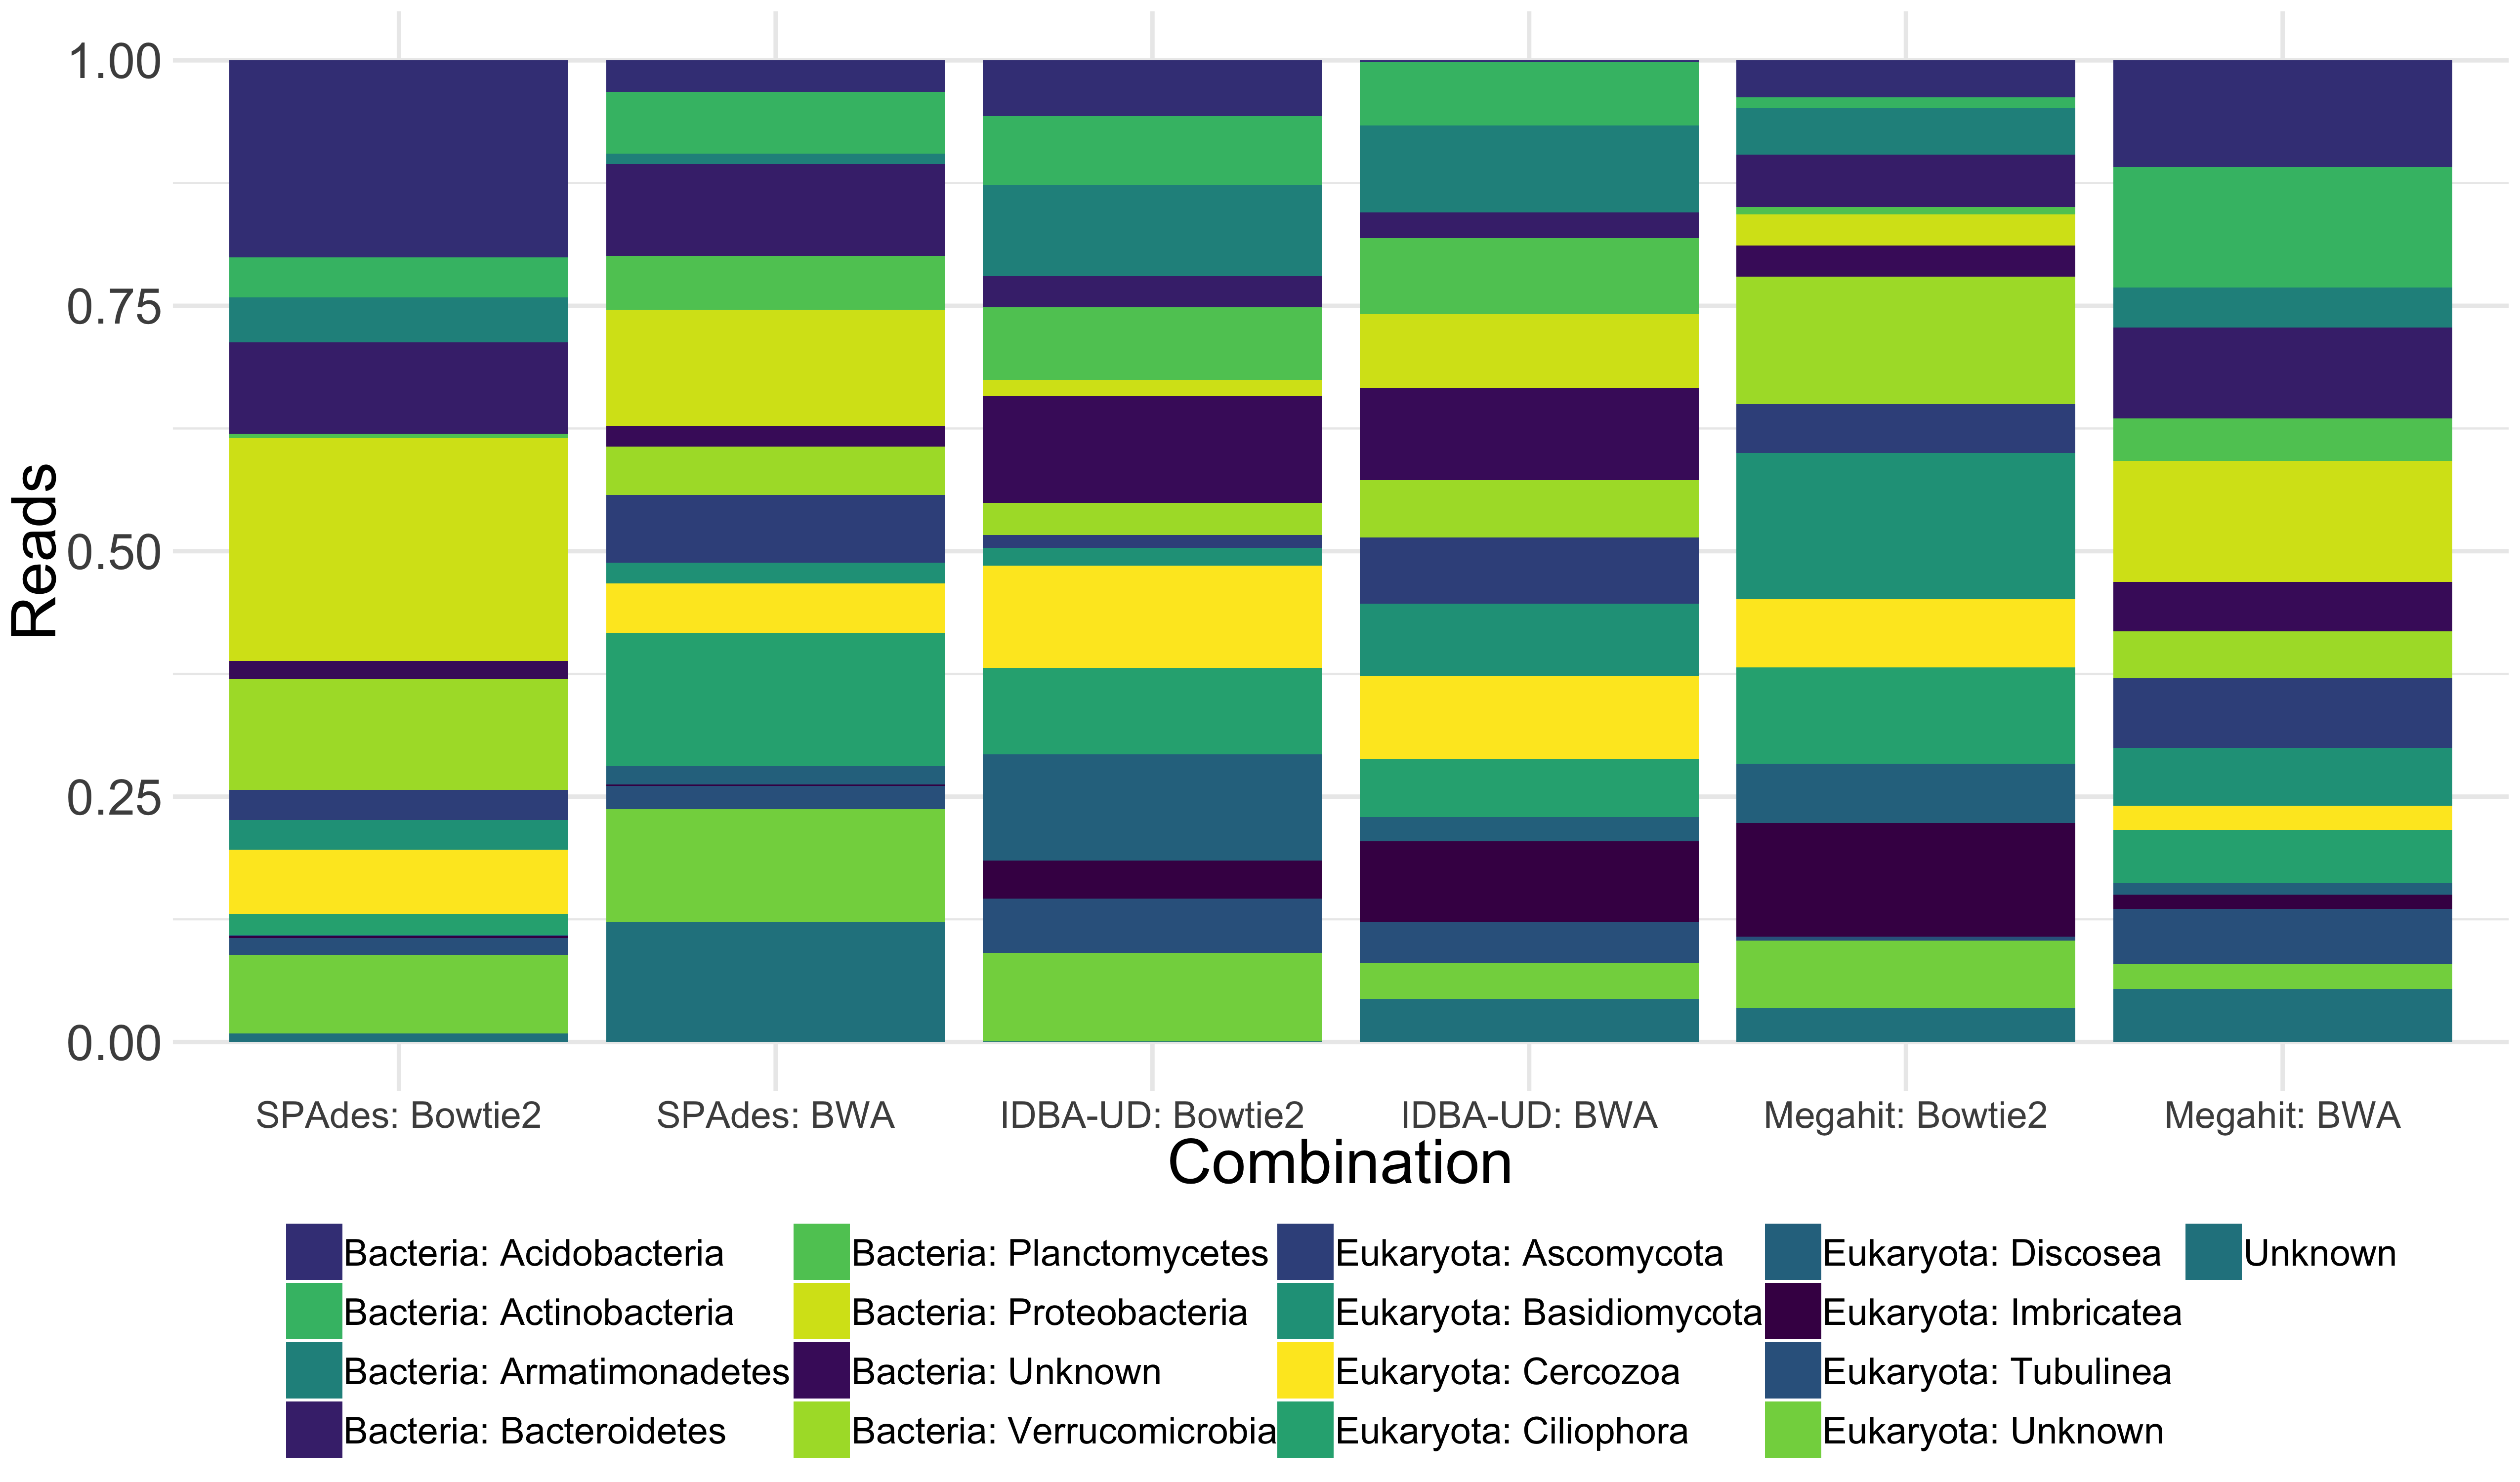

In [8]:
plot2<-ggplot(data=test_stacked_plot, aes(x=Combination, y=Reads, fill=Group))+
  geom_bar(stat="identity")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1)+
  theme(legend.key.size = unit(2,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=18))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  theme(element_line(size = 1))

options(repr.plot.width=17, repr.plot.height=10)
plot2
#ggsave("Plot2.png", plot=plot2,  device="png")  #uncomment if you want to save the plot as .png (currently wrong size, rather save it manually by right-clicking o picture)

### But actually, we have diferent groups of combinations. So we could arrange them more neat. Let's make groups for our plots to tidy them up.

In [9]:
melted <- test_stacked_plot
melted$Category <- c(rep("SPAdes", 34), rep("IDBA-UD", 34), rep("Megahit", 34))
melted$Combination <- c(rep(c(rep("Bowtie2", 17), rep("BWA", 17)), 3))

### And now let's plot these stacked bars in groups.


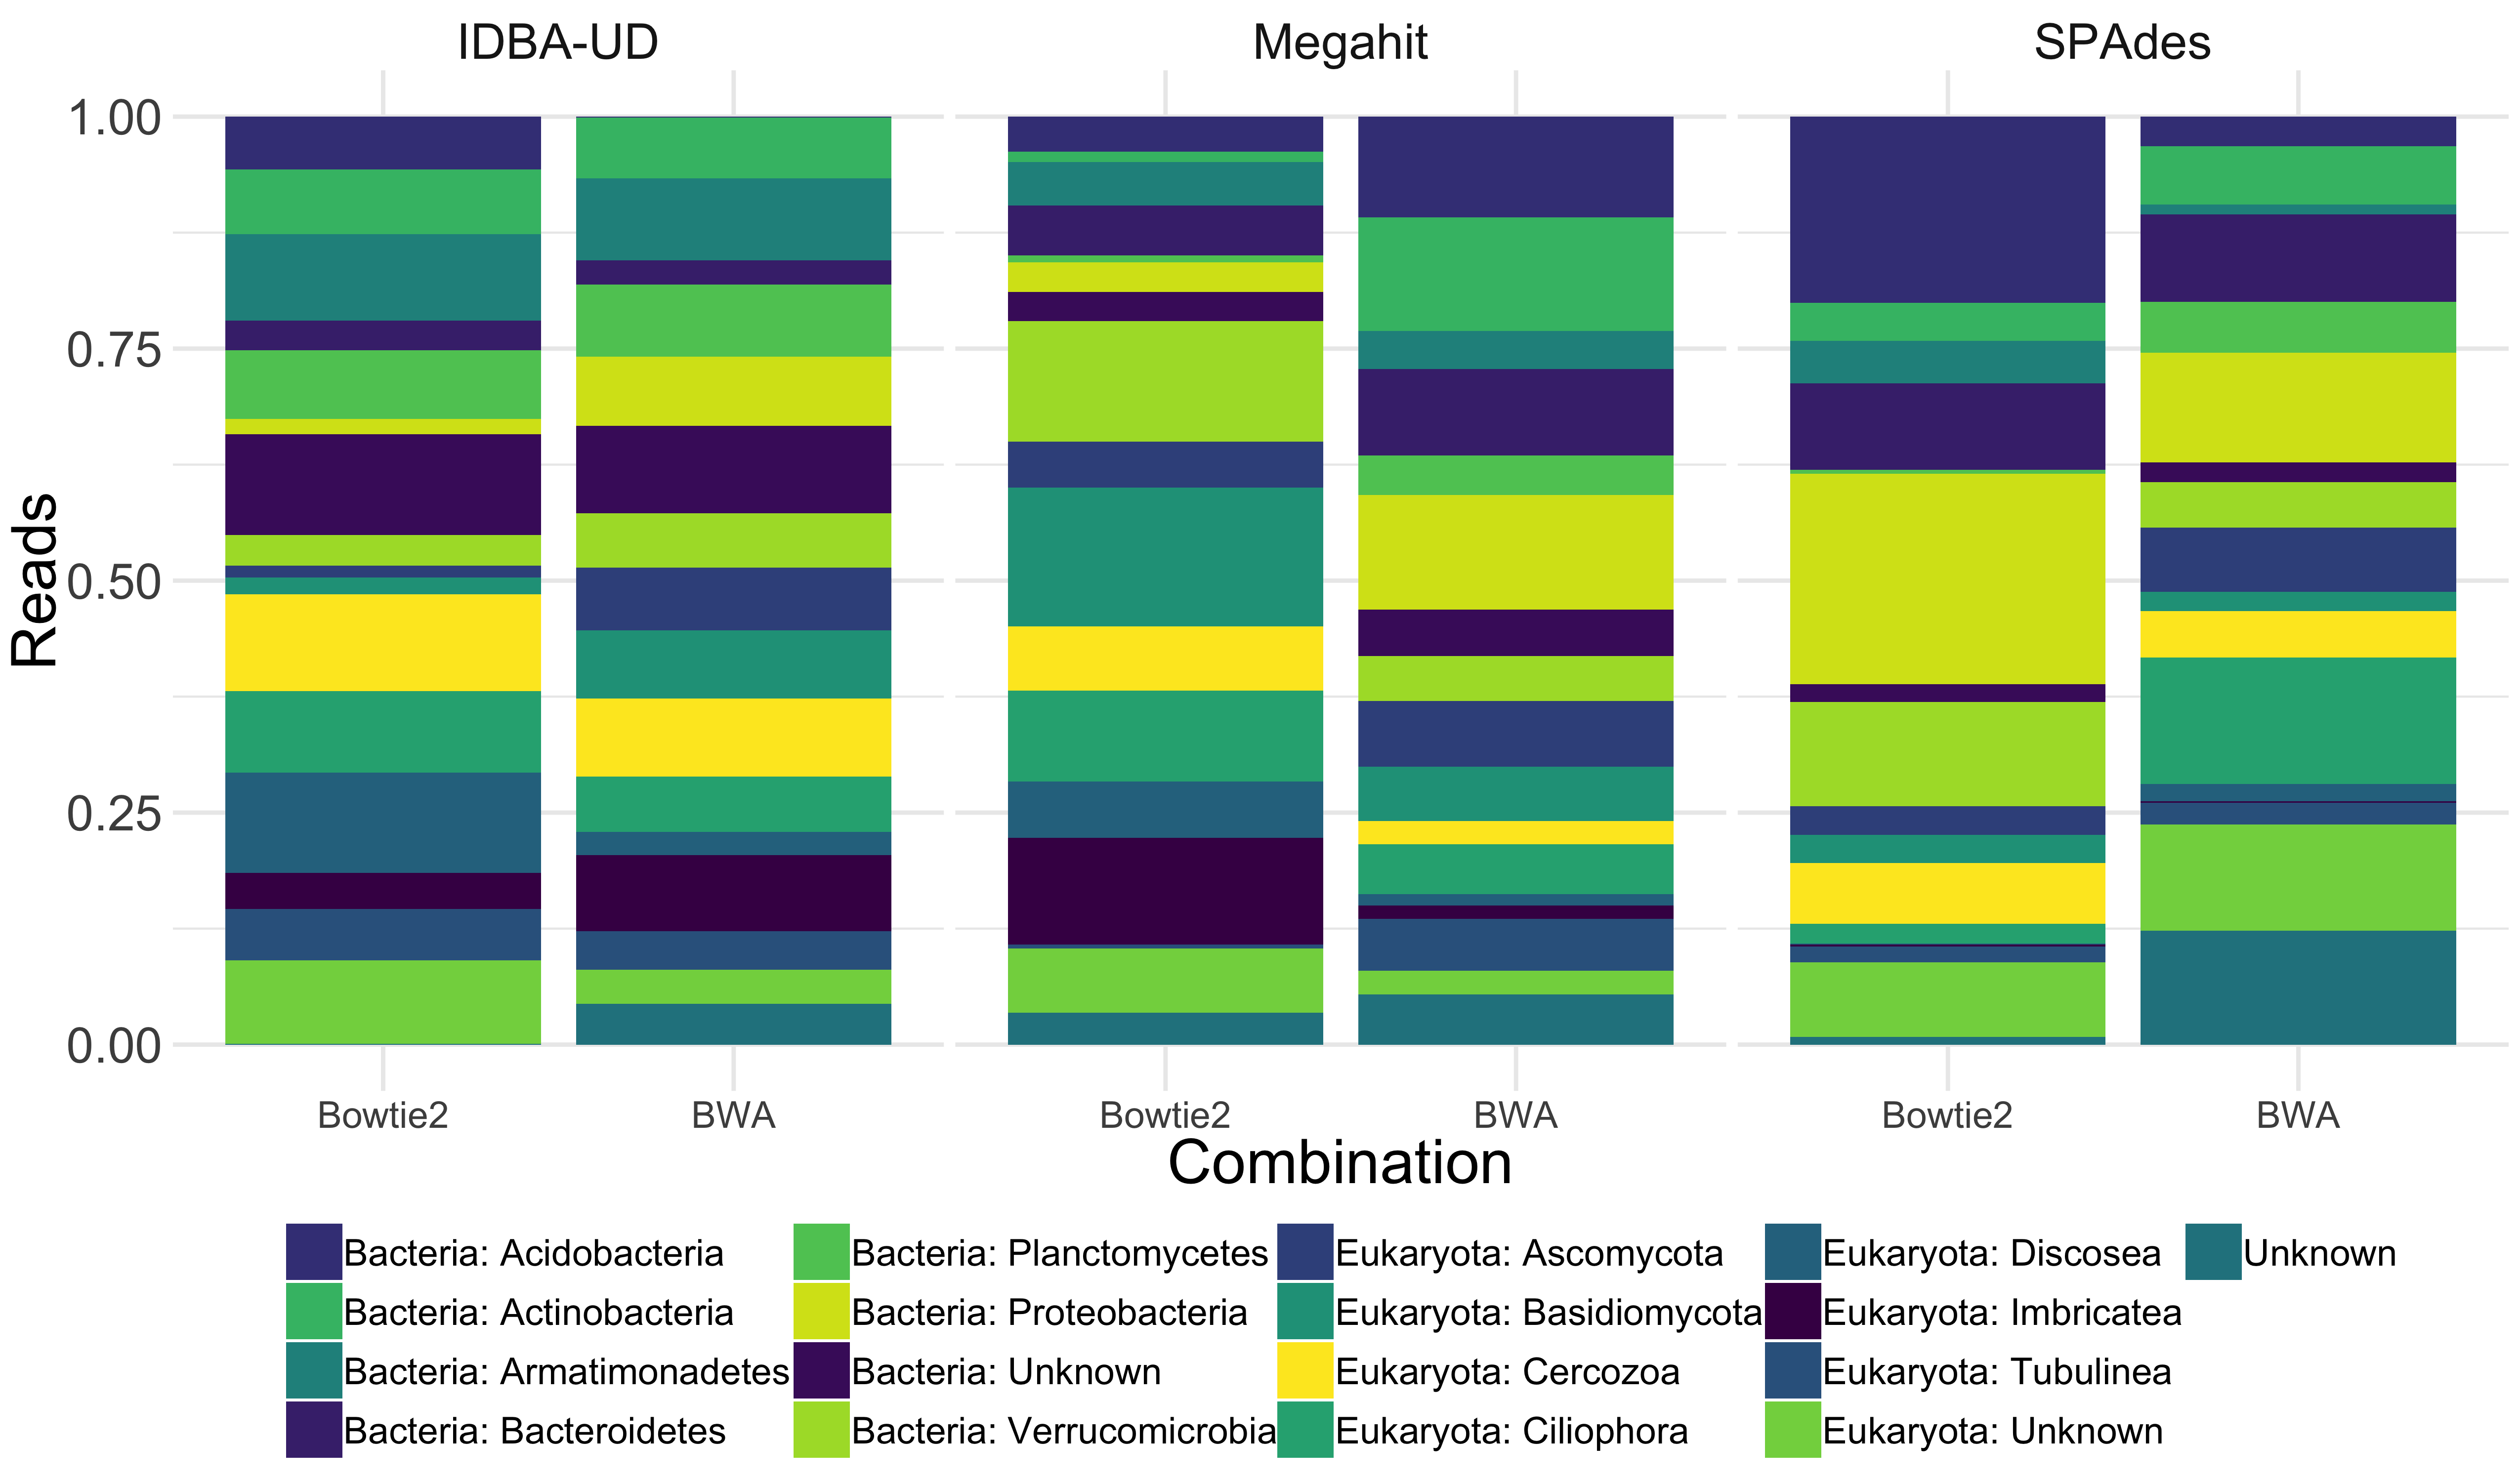

In [10]:
plot3<-ggplot(melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity')+
  facet_grid(~ Category, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1)+
  theme(legend.key.size = unit(2,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=18))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  theme(element_line(size = 1))
options(repr.plot.width=17, repr.plot.height=10)
plot3
#ggsave("Plot3.png", plot=plot3,  device="png")  #uncomment if you want to save the plot as .png (currently wrong size, rather save it manually by right-clicking o picture)

### To be honest though, the colors are a bit ugly. Let's try different colors and generate the plots next to each other to directly compare them - and pick the best colors!

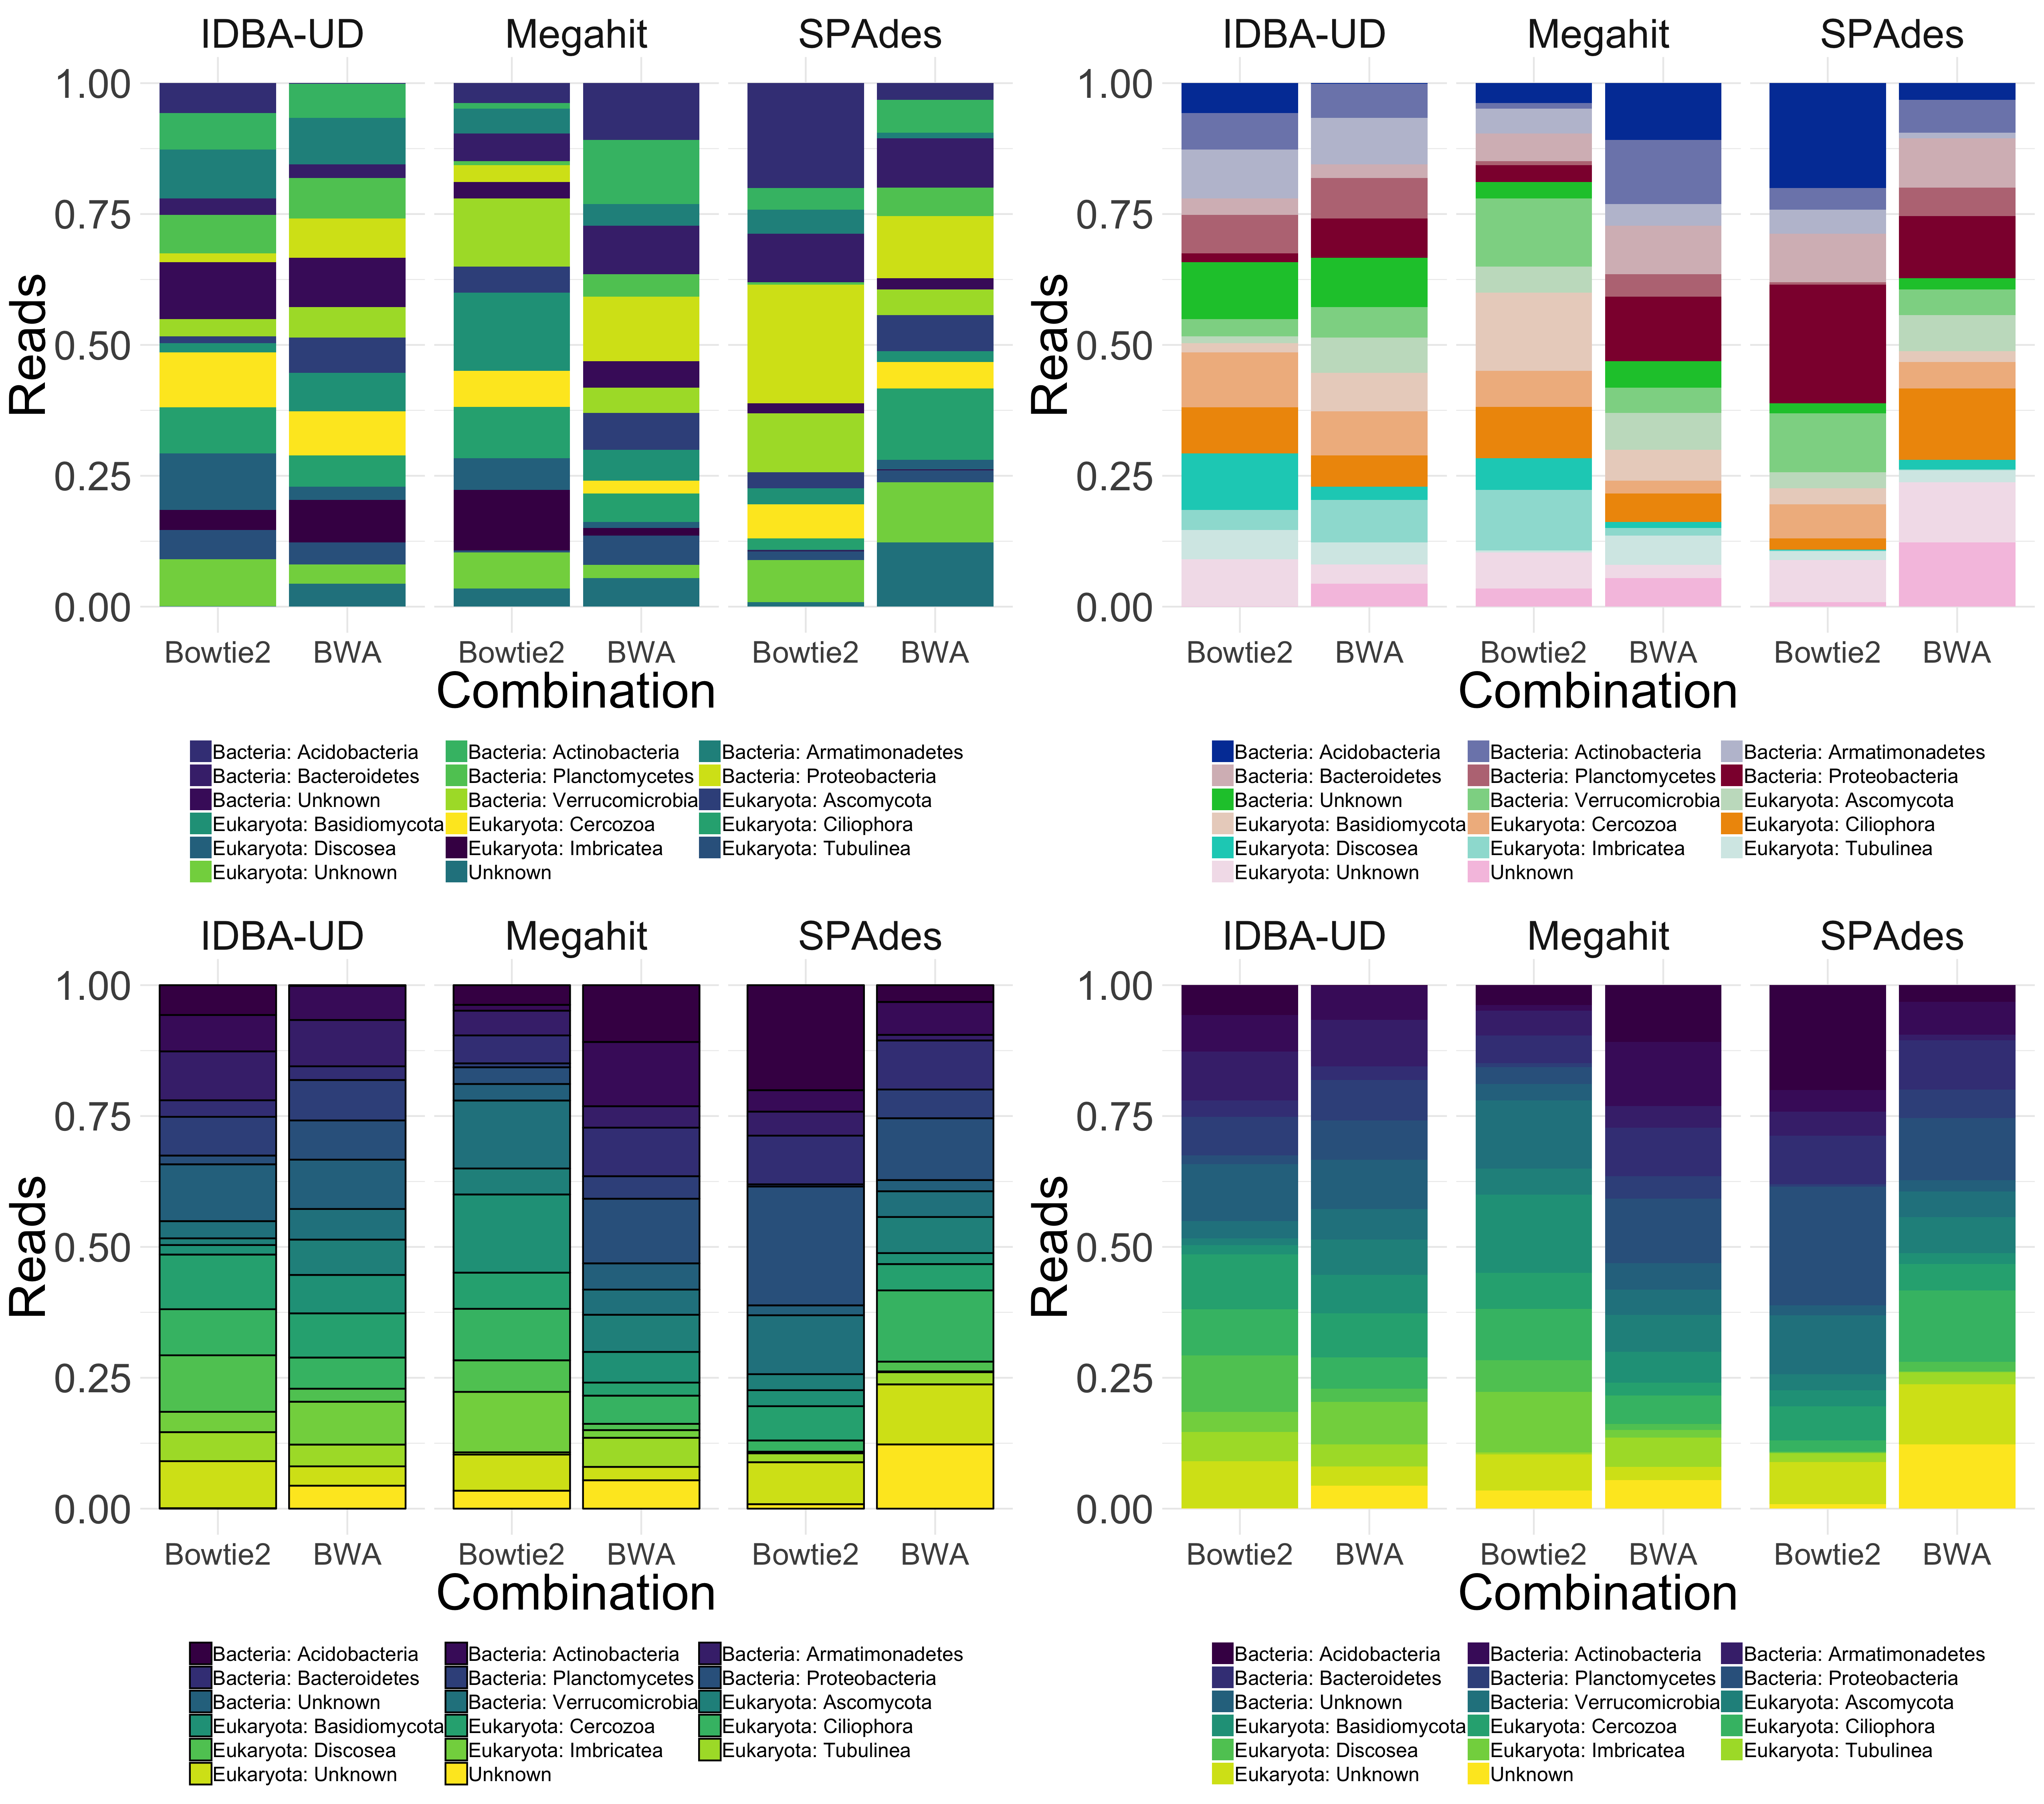

In [11]:
plot4<-ggplot(melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity')+
  facet_grid(~ Category, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec1)+
  theme(legend.key.size = unit(1,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=12))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  guides(fill=guide_legend(nrow=6,byrow=TRUE))

plot5<-ggplot(melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity')+
  facet_grid(~ Category, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec2[1:nrow(melted)])+
  theme(legend.key.size = unit(1,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=12))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  guides(fill=guide_legend(nrow=6,byrow=TRUE))

plot6<-ggplot(melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', colour="black")+
  facet_grid(~ Category, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=viridis_colors)+
  theme(legend.key.size = unit(1,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=12))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  guides(fill=guide_legend(nrow=6,byrow=TRUE))

plot7<-ggplot(melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity')+
  facet_grid(~ Category, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=viridis_colors)+
  theme(legend.key.size = unit(1,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=12))+
  theme(axis.text.x=element_text(size=18))+
  theme(legend.title=element_blank())+
  theme(text = element_text(size = 30))+
  guides(fill=guide_legend(nrow=6,byrow=TRUE))

options(repr.plot.width=17, repr.plot.height=15)
grid_plot <- grid.arrange(plot4, plot5, plot6, plot7, nrow=2, ncol = 2)
#ggsave("Plot4.png", plot=grid_plot,  device="png")  #uncomment if you want to save the plot as .png (currently wrong size, rather save it manually by right-clicking o picture)

### Soooo, which colors are prettiest??